## Khomkin Konstantin, cohort 53DS
Time Series Project, v.2.0 15.02.2023

## Introduction
The goal of the project is to find an optimal model for determining the value of a used car based on historical data: building a forecast of the number of cabs for the next hour to attract more drivers during the peak period using historical data on cab orders at airports.


# Predicting cab bookings

Chetnye Taxi has collected historical data on cab orders at airports. In order to attract more drivers during the peak period, we need to predict the number of cab orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test sample should be at most 48.

You need to:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of size 10% of the original data.
4. Validate the data on the test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column.

## Preparing

In [1]:
# Pandas:
import pandas as pd # we need the Pandas library to work with the dataset

# Numpy:
import numpy as np # we need the numpy library to work with math functions 

# Sklearn:
from sklearn.model_selection import train_test_split # we need the train_test_split function to split the data into samples
from sklearn.tree import DecisionTreeRegressor # Decision Tree model. 
from sklearn.linear_model import LinearRegression # "Linear Regression" model 
from sklearn.ensemble import RandomForestRegressor # "Random Forest" model from sklearn.preprocessing import StandardScaler # data scale standardization method
from sklearn.metrics import mean_squared_error # method for calculating RMSE and vtnhbrb RMSE
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV   
from sklearn.metrics import make_scorer # method to create a method to estimate the model for the crossRvalidation parameter
from sklearn.model_selection import cross_val_score # function of model estimation by crossvalidation method


# Mathlotlib:
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Warnings
import warnings



In [2]:
# apply the try-except construct to load the file both for the local version and for working from the simulator

try:

    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col = 'datetime')
    
    
except:

    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = 'datetime') 

In [3]:
df.head(5) # let's look at the structure of the raw data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.shape # ... and the size of the dataframe

(26496, 1)

In the historical data we have 26.5 thousand records, the data was recorded in 10 minute increments. 

## Analysis

In [5]:
df.sort_index(inplace=True)  # sort time series in ascending order


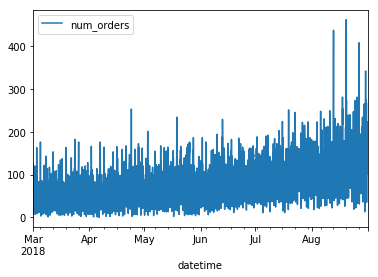

In [6]:
df = df.resample('1H').sum() 
# enlarge the sample to a step of 1 hour, while summarizing the values within an hour (according to the ToR we need a prediction with a step of 1 hour)

df.plot()

We have data for a partial year, it is difficult to understand something from the graph, we need decomposition and trend analysis. Let's look at the trends at different scales

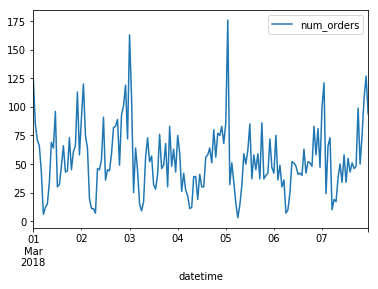

In [7]:
df['2018-03-01':'2018-03-07'].plot() # let's take a look at the 7-day data

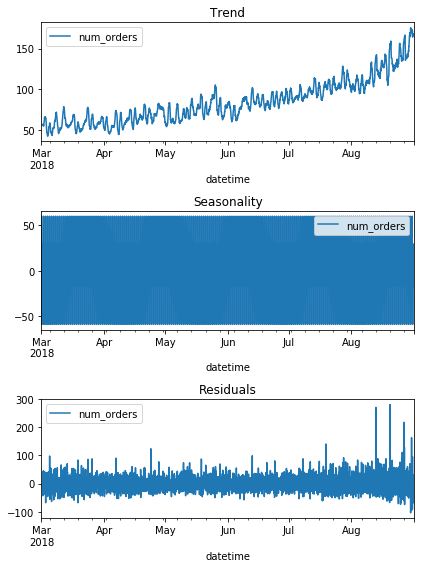

In [8]:
decomposed = seasonal_decompose(df) #Analyze trends and seasonality on complete data



plt.figure(figsize=(6, 8))
plt.subplot(311)

# For the graph to display correctly, we specify its
# axis axes equal to plt.gca(),
# get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The graphs show that there is a general trend of increasing number of orders, i.e. it will be important to take into account the long-term trend when training

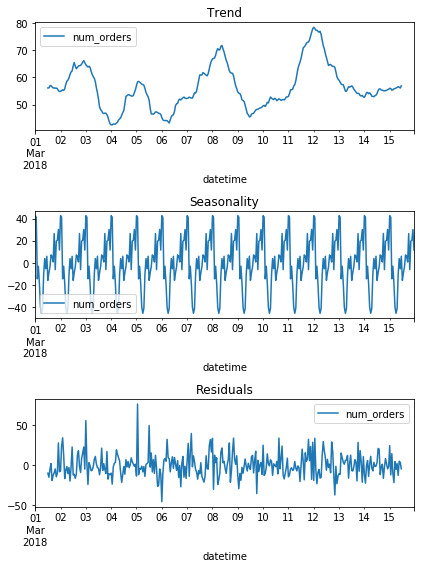

In [9]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-15']) #Analyze trends and seasonality on a 2-week horizon


plt.figure(figsize=(6, 8))
plt.subplot(311)
# For the graph to display correctly, we specify its
# axis axes equal to plt.gca(),
# get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

From the analysis of the two-week chart we can see that there is a pronounced "seasonality" - regular fluctuations in the number of orders every hour within one day. At the same time, there is no dependence on the day of the week (all 15 days of the sample behave the same way)

**Intermediate conclusion:** from the graphs we conclude that the time series has two regularities: 1) a general trend of increasing orders and 2) pronounced "seasonality" at a horizon of 1 day.  Thus, in the sample for model training we will add the column "hour of day" for accurate prediction and take into account the training trend for increase using moving average. Thus, as features we will add lags with 1 hour step for the previous 24 hours, as well as the moving average number of orders per day (average for the past 24 hours).


## Learning

In [10]:
# Declare a universal feature generation function

def make_features(df, max_lag, rolling_mean_size):  
#    df['year'] = df.index.year
#    df['month'] = df.index.month
#    df['day'] = df.index.day
#    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['num_orders_roll_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(df, 24, 24) 
# Call the function with arguments "max lag 24 hours" and "moving average per day".

In [12]:
# 10% of the dataset is allocated to the test sample with the shuffle=False argument, which will prevent the test sample from "looking into the future"

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

# divide the sample into features and target
features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]


In [15]:
# Declare a function to calculate RMSE for use as a cross-validation metric

def rmse_s (trg, prd):
    rmse = mean_squared_error(trg, prd)**0.5
    return rmse

# Apply make_scorer to declare the new metric
rmse_scorer = make_scorer(rmse_s, greater_is_better=False)  

In [16]:
models = {}

# Declare a LinearRegression() model
models[0] = LinearRegression() 

# Declare the DecisionTreeRegressor() model 
models[1] = DecisionTreeRegressor(random_state=12345)

# Declare a RandomForestRegressor() model with
models[2] = RandomForestRegressor(random_state=12345)

# Add the RMSE metrics of all models to the variable
Models_scores = {}

In [17]:
# Apply cross validation to determine the average RMSE metric of the LinearRegression model

Models_scores[0] = abs(cross_val_score(models[0], features_train, target_train, scoring=rmse_scorer, cv=5).mean())

print('Модель: ', models[0])
print('RMSE: ', Models_scores[0])

Модель:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
RMSE:  25.888198662581647


In [18]:
# Apply cross validation and GridSearch to determine the DecisionTreeRegressor model hyperparameters and best RMSE metric

param_search = {'max_depth' : [1, 3, 5, 10, 15]}


tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=models[1], cv=tscv,
                        param_grid=param_search,
                        scoring=rmse_scorer)
model_grid = gsearch.fit(features_train, target_train)
 
Models_scores[1] =   abs(model_grid.best_score_)
print('Модель: ', models[1])
print('Лучшие гиперпараметры: '+str(model_grid.best_params_))
print('RMSE: ', Models_scores[1])

Модель:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=12345, splitter='best')
Лучшие гиперпараметры: {'max_depth': 5}
RMSE:  30.419815910690517


In [19]:
# Apply cross validation and GridSearch to determine the RandomForestRegressor model hyperparameters and the best RMSE metric


param_search = {'n_estimators' : [5, 10, 15, 20], 'max_depth' : [5, 10, 15, 20, 25]}

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=models[2], cv=tscv,
                      param_grid=param_search,
                      scoring=rmse_scorer)
model_grid = gsearch.fit(features_train, target_train)
 
Models_scores[2] =   abs(model_grid.best_score_)
print('Модель: ', models[1])
print('Лучшие гиперпараметры: '+str(model_grid.best_params_))
print('RMSE: ', Models_scores[2])

Модель:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=12345, splitter='best')
Лучшие гиперпараметры: {'max_depth': 15, 'n_estimators': 20}
RMSE:  25.762550296624173


In [30]:
print(f'Минимальная RMSE у модели №{min(Models_scores, key=Models_scores.get)}, среднеквадратичная ошибка {Models_scores[min(Models_scores, key=Models_scores.get)]:.6}' )
print('Лучшая модель:',models[min(Models_scores, key=Models_scores.get)])

Минимальная RMSE у модели №2, среднеквадратичная ошибка 25.7626
Лучшая модель: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=12345, verbose=0,
           warm_start=False)


Intermediate conclusion: by applying crossvalidation and GridSearch for hyperparameter selection, we identified the best model: RandomForestRegressor with hyperparameters {'max_depth': 15, 'n_estimators': 20}

## Testing

In [26]:
# Test the best model on a test sample and make a final prediction

# Declare the model with the best hyperparameters:
model = RandomForestRegressor(random_state=12345, max_depth=15, n_estimators=20)

#Train the model on the training sample:
model.fit(features_train, target_train)


#Prediction:
prediction = model.predict(features_test)     

#Calculate the RMSE metric of the final model
RMSE = mean_squared_error(target_test, prediction)**0.5     



In [27]:
# To enable graphing, transform the array of prediction results into dataframes

prediction = pd.DataFrame(data=prediction, index=target_test.index, columns=['num_orders'])

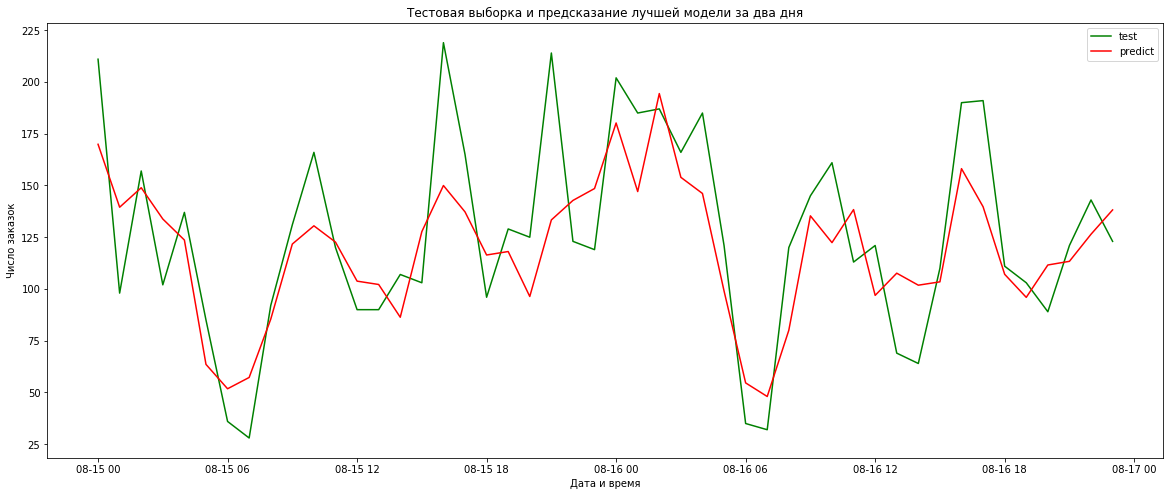

Итоговая среднеквадратичная ошибка: 44.8951


In [28]:
# Let's plot and compare the test sample and the predictions of the best model over 2 days
plt.figure(figsize=(20, 8))
plt.plot(target_test['2018-08-15':'2018-08-16'], color='g', label='test')
#plt.plot(Prediction_valid[min(RMSE, key=RMSE.get)]['2018-08-15':'2018-08-16'],  color='r', label='predict')
plt.plot(prediction['2018-08-15':'2018-08-16'],  color='r', label='predict')

plt.xlabel("Дата и время")
plt.ylabel("Число заказок")
plt.title("Тестовая выборка и предсказание лучшей модели за два дня")
plt.legend()
  
plt.show()
print(f'Итоговая среднеквадратичная ошибка: {RMSE:.6}')

## Conclusions :

The project analyzed a time series (data on the number of cab orders near the airport) and built a model predicting the number of orders in 1 hour increments.

Trends and seasonality in the data were analyzed and it was found that there is a general trend of increasing number of orders, as well as a pronounced daily seasonality - fluctuations in the number of orders per hour, repeated every day regardless of the day of the week.
Based on this analysis, the "hour of day" column was added to the original sample, and new features were generated: 1) the number of orders in 1-hour increments, retrospectively backward 1 day and 2) the average number of orders (24-hour moving average)

GridSearchCV (for DecisionTreeRegressor and RandomForestRegressor models) and cross_val_score (for LinearRegression) techniques were applied to fit the hyperparameters of the models and select the model with the best RMSE metric, and the final model was selected based on the "minimum RMSE metric" criterion:
RandomForestRegressor with hyperparameters n_estimators=20, max_depth = 15, which showed an RMSE of 44.8951 on the test sample

For clarity, the graph shows the test sample data for two days (August 15 and 16, 2018) and the prediction results of the best model